In [58]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sps
from datetime import datetime

%matplotlib inline

### Preprocessing

Read the data.

In [2]:
col_names = ['user_id', 'friend_id']
df = pd.read_csv('Gowalla_edges.txt', sep='\t', names=col_names)

In [3]:
df.head()

,user_id,friend_id
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900654 entries, 0 to 1900653
Data columns (total 2 columns):
user_id      int64
friend_id    int64
dtypes: int64(2)
memory usage: 29.0 MB


Initialize S (Similarity), A (Availability) and R (Responsibility) matrices.

In [5]:
n_users = df['user_id'].nunique()

In [6]:
rows = df['user_id'].values
cols = df['friend_id'].values
data = np.ones(df.shape[0])

In [7]:
coo_mtx = sps.coo_matrix((data, (rows, cols)), shape=(n_users, n_users))

In [8]:
S = coo_mtx.tocsr()
S.setdiag(-1)

/usr/local/lib/python3.6/dist-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [9]:
A, R = S.copy(), S.copy()
A.data, R.data = np.zeros(len(S.data), dtype=np.float64), np.zeros(len(S.data), dtype=np.float64)

Some auxiliary arrays.

In [10]:
indptr = S.indptr
indices = S.indices
ind_range = np.arange(n_users)

In [11]:
nz_cols = [indices[start_idx:end_idx].tolist() 
           for start_idx, end_idx in zip(indptr, indptr[1:])]

In [12]:
idx_to_col = [dict(zip(ind_range, chunk)) for chunk in nz_cols]

### AP-algorithm implementation

In [13]:
def row_generator(X):
    for start_idx, end_idx in zip(indptr, indptr[1:]):
        yield X.data[start_idx:end_idx]

In [14]:
def row_max(X):
    m_ind, m_val = [], []

    for row in row_generator(X):
        m_ind.append(np.argmax(row))
        m_val.append(np.max(row))

    # assign the corresponding max value to each element of sparse matrix data
    m_arr = np.repeat(np.array(m_val).T, np.diff(indptr))
    return m_ind, m_val, m_arr

In [15]:
def update_r(A, S, R, damping=0.5):
    temp = S.copy()
    temp.data += A.data

    fm_ind, fm_val, fm_arr = row_max(temp)
    temp[ind_range, fm_ind] = -np.inf
    _, _, sm_arr = row_max(temp)

    # replace first maximum values by second ones where idx is the index of max value
    for idx, val in enumerate(indptr[:-1]):
        col_idx = val + fm_ind[idx]
        fm_arr[col_idx] = sm_arr[col_idx]

    R_new = S.copy()
    R_new.data = R.data * damping + (1 - damping) * (R_new.data - fm_arr)
    return R_new

In [16]:
def update_a(R, A, damping=0.5):
    A_new = R.copy()
    A_new.setdiag(0)
    A_new[A_new < 0] = 0

    col_sums = np.sum(A_new, axis=0).A.flatten()
    arr_sums = R.diagonal() + col_sums
    
    # also substract values that should not be included into the sums
    A_new.data = np.minimum(0, arr_sums[indices] - A_new.data)

    A_new.setdiag(col_sums)
    A_new.data = A.data * damping + (1 - damping) * A_new.data
    return A_new

In [17]:
def labels(A, R):
    temp = A.copy()
    temp.data += R.data
    ind_data, _, _ = row_max(temp)

    return [mapper[idx] for idx, mapper in zip(ind_data, idx_to_col)]

In [18]:
max_iters = 300
exemplars_log = []

In [19]:
start_time = datetime.now()

In [20]:
for _ in range(max_iters):
    R = update_r(A, S, R)
    A = update_a(R, A)
    c = labels(A, R)

    exemplars_log.append(c)

end_time = datetime.now()

/usr/local/lib/python3.6/dist-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [21]:
timedelta = end_time - start_time

print(f"Training took {timedelta.seconds // 60} minutes")

Training took 35 minutes


Some information about clustering.

In [22]:
counter = collections.Counter(exemplars_log[-1])

In [23]:
print(f"Number of exemplars (clusters): {len(counter)}")

Number of exemplars (clusters): 54372


In [25]:
n_singles = sum(val == 1 for val in counter.values())

print(f"Number of clusters of size = 1: {n_singles}")

Number of clusters of size = 1: 27279


In [90]:
groups = collections.defaultdict(list)

for val in counter.values():
    if val < 10:
        groups[0].append(val)
    elif val < 100:
        groups[1].append(val)
    elif val < 1000:
        groups[2].append(val)
    else:
        groups[3].append(val)

In [91]:
def hist(x, ax, interval):
    n, bins, patches = ax.hist(x, bins=10, color='b', edgecolor='k', alpha=0.5)
    ax.set_ylabel("number of clusters")
    ax.set_xlabel("number of users")
    ax.set_title(f"Histogram of clusters of size in {interval}")

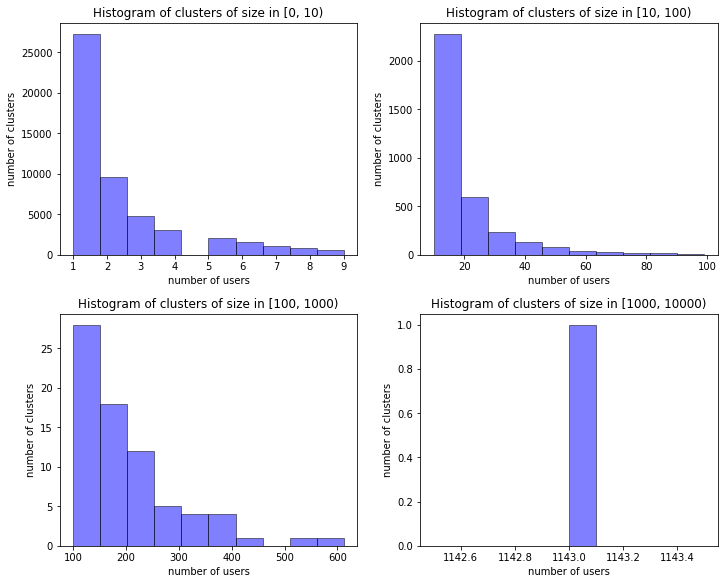

In [101]:
fig, axes = plt.subplots(nrows=2, ncols=2, 
                         figsize=(10, 8), 
                         constrained_layout=True)

intervals = ['[0, 10)', '[10, 100)', '[100, 1000)', '[1000, 10000)']
for x, ax, interval in zip(sorted(groups.values()), axes.flat, intervals):
    hist(x, ax, interval)

plt.show()

### Recommendations

Read check-in information.

In [27]:
col_names = ['user_id', 'time', 'latitude', 'longitude', 'location_id']
df_checkins = pd.read_csv('Gowalla_totalCheckins.txt', sep='\t', names=col_names)

In [28]:
df_checkins.head()

,user_id,time,latitude,longitude,location_id
0,0,2010-10-19T23:55:27Z,30.235909,-97.795140,22847
1,0,2010-10-18T22:17:43Z,30.269103,-97.749395,420315
2,0,2010-10-17T23:42:03Z,30.255731,-97.763386,316637
3,0,2010-10-17T19:26:05Z,30.263418,-97.757597,16516
4,0,2010-10-16T18:50:42Z,30.274292,-97.740523,5535878


In [29]:
df_checkins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6442892 entries, 0 to 6442891
Data columns (total 5 columns):
user_id        int64
time           object
latitude       float64
longitude      float64
location_id    int64
dtypes: float64(2), int64(2), object(1)
memory usage: 245.8+ MB


In [30]:
df_checkins.drop(columns=['time', 'latitude', 'longitude'], inplace=True)

In [31]:
df_checkins['user_id'].nunique() == df['user_id'].nunique()

False

Select some users with check-ins for the test set.

In [33]:
df_exemplars = pd.DataFrame({
    'user_id': np.arange(n_users),
    'exemplar_id': exemplars_log[-1]
})

In [46]:
test_perc = 10
n_test = df_checkins['user_id'].nunique() // 100 * test_perc
n_test

10700

In [47]:
users = df_checkins['user_id'].unique()
np.random.shuffle(users)
test = users[:n_test]

Count check-ins for each cluster.

In [36]:
clusters = collections.defaultdict(list)

for user_id, exemplar_id in df_exemplars.itertuples(index=False): 
    if not (exemplar_id == user_id and exemplar_id in test):
        clusters[exemplar_id].append(user_id)

In [39]:
locations = collections.defaultdict(collections.Counter)

for exemplar_id, cluster in clusters.items():
    checkins = df_checkins[df_checkins['user_id'].isin(cluster)]['location_id'].values
    locations[exemplar_id].update(checkins)

Get recommendations for the test set.

In [48]:
df_test = df_exemplars[df_exemplars['user_id'].isin(test)]

In [49]:
n_top = 10

In [50]:
test_checkins = {}
recommendations = {}

for user_id, exemplar_id in df_test.itertuples(index=False):
    checkins = df_checkins[df_checkins['user_id'] == user_id]['location_id'].values
    test_checkins[user_id] = checkins

    top = [loc_id for loc_id, counts in locations[exemplar_id].most_common(n_top)]
    recommendations[user_id] = top

Calculate the accuracy.

In [51]:
scores = []

for user_id, checkins in test_checkins.items():
    top = recommendations[user_id]
    n_misses = n_top - len(top)

    acc = np.maximum(0, (len(set(top) & set(checkins)) - n_misses) / n_top)
    scores.append(acc)

In [52]:
np.mean(scores)

0.28313084112149534

In [53]:
collections.Counter(scores)

Counter({0.2: 887,
         0.0: 4459,
         1.0: 1293,
         0.1: 1504,
         0.8: 297,
         0.7: 285,
         0.4: 453,
         0.3: 564,
         0.9: 277,
         0.6: 314,
         0.5: 367})